In [1]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel, HRFModel, spm_hrf#, gamma_pdf_with_loc, gamma_pdf
from braincoder.utils import logit
from braincoder.optimize import ParameterFitter
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.math import sigmoid
from braincoder.utils.data import load_szinte2024
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

data = load_szinte2024()
paradigm = data['stimulus']
grid_coordinates = data['grid_coordinates']
d = data['v1_timeseries']
d.index.name = 'frame'
tr = data['tr']

2025-08-19 15:41:19.034615: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-19 15:41:19.034694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-19 15:41:19.034710: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-19 15:41:19.471423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/daghlian/.conda/envs/bcode

## HRF Parameters are not fit - Results as Expected

Working with chunk size of 1879


2025-08-19 15:42:00.319386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6824 MB memory:  -> device: 0, name: Tesla P4, pci bus id: 0000:03:00.0, compute capability: 6.1
  0%|          | 0/1 [00:00<?, ?it/s]2025-08-19 15:42:03.688095: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 6.1
2025-08-19 15:42:03.688137: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2025-08-19 15:42:03.688272: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-19 15:42:03.688340: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-19 15:42:03.688580:

*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
Number of problematic voxels (mask): 57
Number of voxels remaining (mask): 2308


  0%|          | 0/1000 [00:00<?, ?it/s]2025-08-19 15:42:11.527618: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-19 15:42:13.733593: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-19 15:42:13.911759: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-19 15:42:14.286577: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563ee8a93950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-19 15:42:14.286650: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P4, Compute Capability 6.1
2025-08-19 15:42:14.381355: I ten

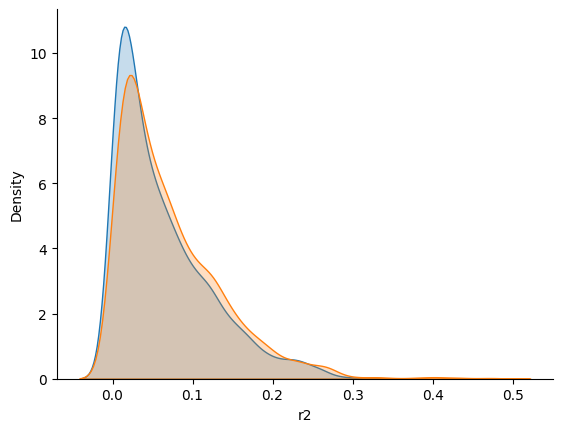

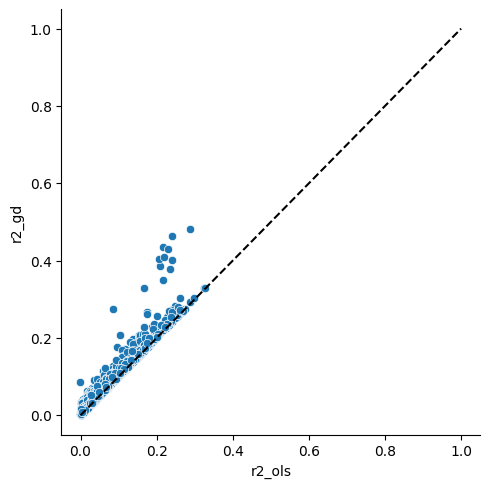

In [2]:
hrf_model = SPMHRFModel(tr)
model_gauss = GaussianPRF2DWithHRF(data=d, paradigm=paradigm, hrf_model=hrf_model, grid_coordinates=grid_coordinates)
par_fitter = ParameterFitter(model=model_gauss, data=d, paradigm=paradigm)
x = np.linspace(-8, 8, 10)
y = np.linspace(-4, 4, 10)
sd = np.linspace(0.1, 4, 10)


baseline = [0.0]
amplitude = [1.0]

pars_gauss_grid = par_fitter.fit_grid(x, y, sd, baseline, amplitude, correlation_cost=True)
pars_gauss_ols = par_fitter.refine_baseline_and_amplitude(pars_gauss_grid)
r2_gauss_ols = par_fitter.get_rsq(pars_gauss_ols)
sns.kdeplot(r2_gauss_ols, fill=True)
sns.despine()

pars_gauss_gd = par_fitter.fit(init_pars=pars_gauss_ols, max_n_iterations=1000)
r2_gauss_gd = par_fitter.get_rsq(pars_gauss_gd)
sns.kdeplot(r2_gauss_gd, fill=True)

r2 = pd.concat((r2_gauss_ols, r2_gauss_gd), keys=['r2_ols', 'r2_gd'], axis=1)
sns.relplot(x='r2_ols', y='r2_gd', data=r2.reset_index(), kind='scatter')
plt.plot([0, 1], [0, 1], 'k--')

*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 57
Number of voxels remaining (mask): 2308


  0%|          | 0/1000 [00:00<?, ?it/s]

(1, 150, 2365) (24, 2365)


2025-08-19 15:43:21.280701: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-19 15:43:22.023817: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
Current R2: 0.10704/Best R2: 0.10705: 100%|██████████| 1000/1000 [00:43<00:00, 22.93it/s]


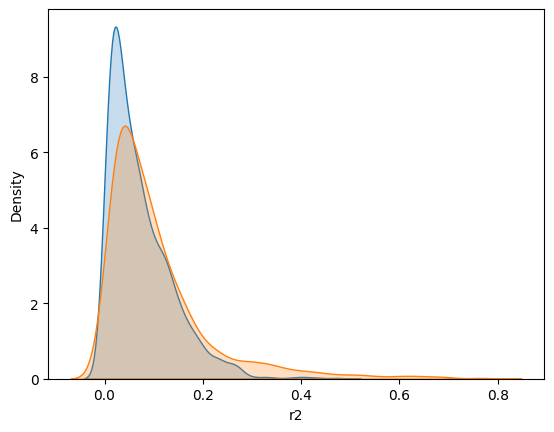

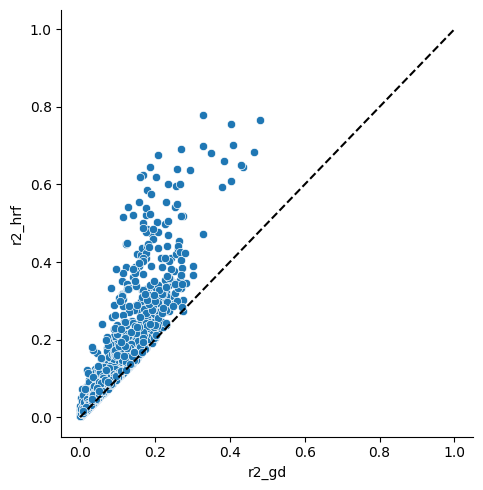

In [3]:

model_hrf = GaussianPRF2DWithHRF(data=d, paradigm=paradigm, hrf_model=hrf_model,
                             grid_coordinates=grid_coordinates, flexible_hrf_parameters=True)

par_fitter_hrf = ParameterFitter(model=model_hrf, data=d, paradigm=paradigm)

pars_gauss_gd['hrf_delay'] = 6.
pars_gauss_gd['hrf_dispersion'] = 1.

pars_gauss_hrf = par_fitter_hrf.fit(init_pars=pars_gauss_gd, max_n_iterations=1000, store_intermediate_parameters=True, learning_rate=0.01)
r2_gauss_hrf = par_fitter_hrf.get_rsq(pars_gauss_hrf)

sns.kdeplot(r2_gauss_gd, fill=True)
sns.kdeplot(r2_gauss_hrf, fill=True)

r2 = pd.concat((r2_gauss_gd, r2_gauss_hrf), keys=['r2_gd', 'r2_hrf'], axis=1)
sns.relplot(x='r2_gd', y='r2_hrf', data=r2.reset_index(), kind='scatter')
plt.plot([0, 1], [0, 1], 'k--')

In [9]:
model_hrf.parameter_labels

['x', 'y', 'sd', 'baseline', 'amplitude', 'hrf_delay', 'hrf_dispersion']

/tmp/ipykernel_906987/1381862822.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp = pred.stack(['model', 'source']).to_frame('value')


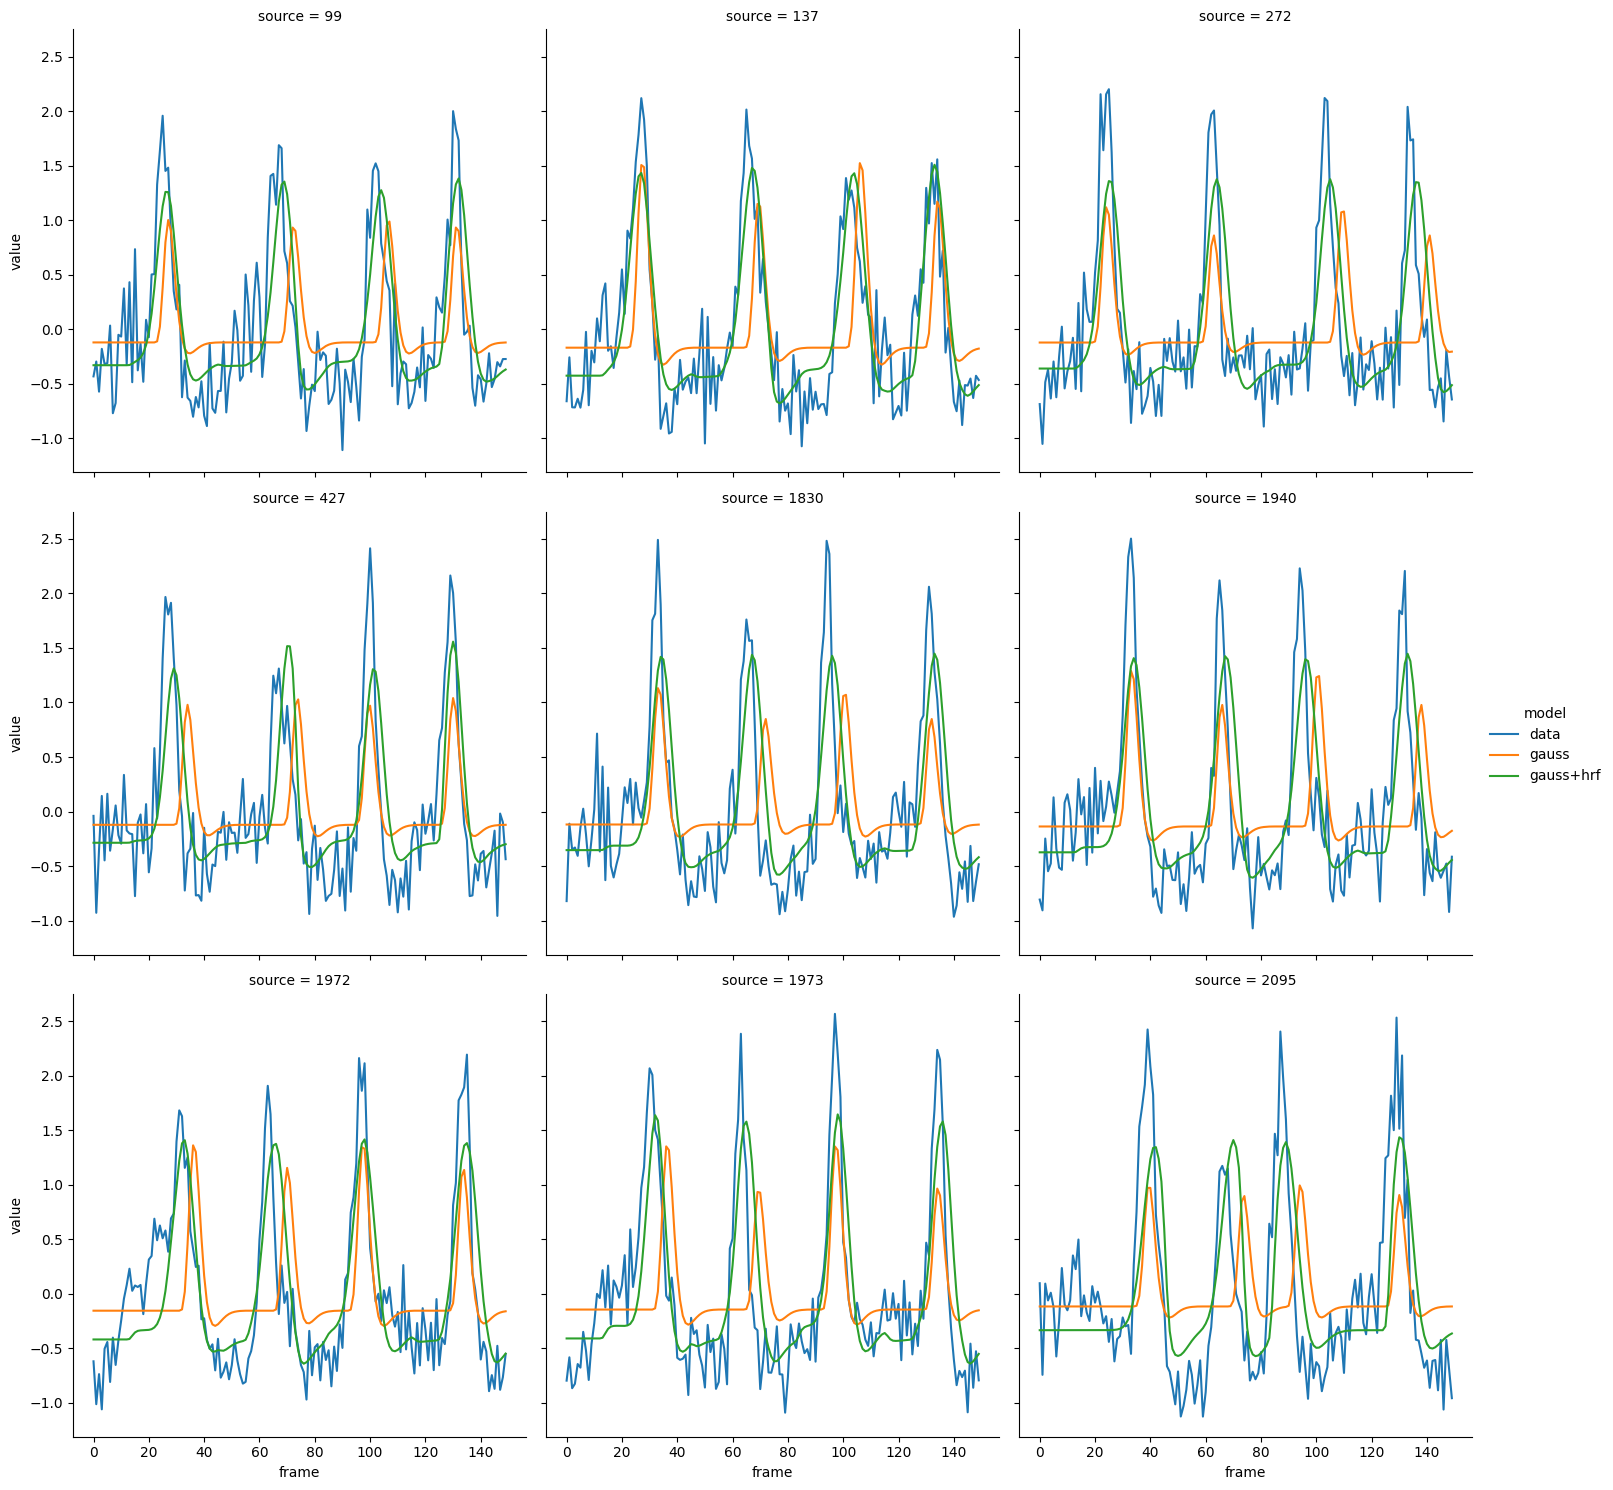

In [4]:
improvement = r2_gauss_hrf - r2_gauss_gd
largest_improvements = improvement.sort_values(ascending=False).index[:9]
pred_gauss_gd = model_gauss.predict(parameters=pars_gauss_gd)
pred_gauss_hrf = model_hrf.predict(parameters=pars_gauss_hrf)
pred = pd.concat((d.loc[:, largest_improvements], pred_gauss_gd.loc[:, largest_improvements], pred_gauss_hrf.loc[:, largest_improvements]), axis=1, keys=['data', 'gauss', 'gauss+hrf'], names=['model'])

#
tmp = pred.stack(['model', 'source']).to_frame('value')
sns.relplot(x='frame', y='value', hue='model', col='source', data=tmp.reset_index(), kind='line', col_wrap=3)

In [5]:
pars_gauss_hrf

parameter,x,y,sd,baseline,amplitude,hrf_delay,hrf_dispersion
source,,,,,,,
0,1.040706,1.630178,0.049708,-0.086969,0.470542,7.955668,0.550720
1,1.931707,0.496914,0.050061,-0.068394,0.336781,7.307148,0.507280
2,3.102575,0.466111,0.045642,-0.091197,1.022537,6.677817,0.687178
3,2.824504,0.283856,0.049298,-0.073114,0.352015,7.136411,0.642319
4,4.517888,0.311157,0.070761,-0.064815,0.820290,5.275584,0.623736
...,...,...,...,...,...,...,...
2360,1.364764,2.181644,0.072365,-0.029660,0.467400,6.906508,0.507619
2361,7.479776,1.802546,0.063421,-0.031145,0.502372,5.649264,0.514235
2362,-8.755578,0.853493,0.072847,-0.027253,0.370979,7.212760,0.505411


<Axes: xlabel='hrf_delay', ylabel='Count'>

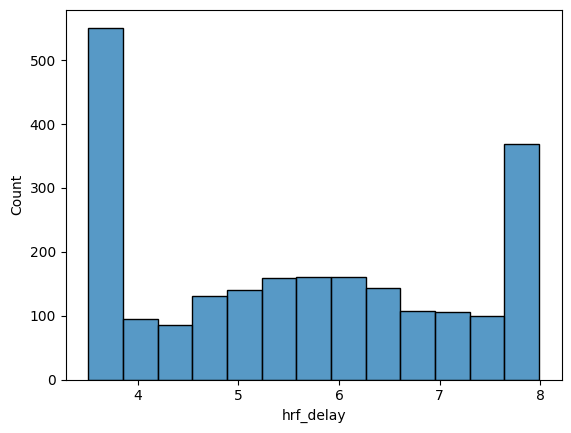

In [6]:
mask = pars_gauss_hrf['hrf_delay'] > 0.0
sns.histplot(pars_gauss_hrf[mask]['hrf_delay'])

<Axes: xlabel='hrf_dispersion', ylabel='Count'>

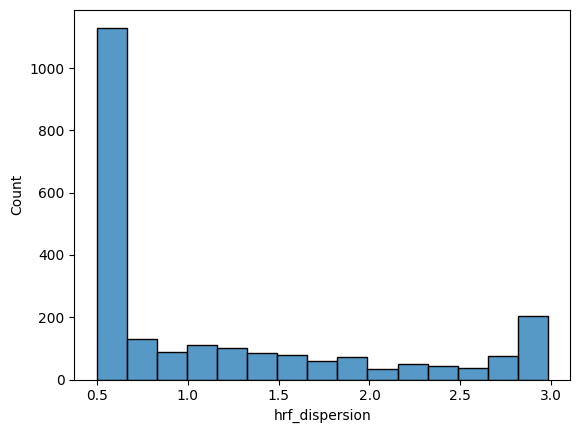

In [7]:
sns.histplot(pars_gauss_hrf[mask]['hrf_dispersion'])